# Set up env

In [1]:
import carla
import numpy as np
from src.simulator import Simulator
from src.agent import NCPAgent
from src.model import Model

import torchvision
from IPython.display import display
import sys
import os
import torch

sys.path.append("CARLA_SIM/PythonAPI/carla/")
from agents.navigation.basic_agent import BasicAgent


# Data collection

In [2]:
import carla
from random import random

random_rotation = 3 * random() - 1.5
mapping = {
    'Town01_opt': {
        'loc': carla.Location(x=176.589493, y=133.239151, z=0.300000), # 15 spawn point
        'rotation': carla.Rotation(0, 0 + random_rotation, 0)
    },
    'Town02_opt': {
        'loc': carla.Location(x=193.779999, y=142.190002, z=0.500000), # 15 spawn point
        'rotation': carla.Rotation(0, -90 + random_rotation, 0)
    },
    'Town03_opt': {
        # 'loc': carla.Location(x=-88.710991, y=-119.565231, z=0.275307), # 1 spawn point
        # 'rotation': carla.Rotation(0, 90 + random_rotation, 0)
        'loc': carla.Location(x=-0.710991, y=-120.565231, z=0.275307), # 1 spawn point
        'rotation': carla.Rotation(0, 90 + random_rotation, 0)
    },
    'Town04_opt': {
        'loc': carla.Location(405.320374, -48.450779, 0.281942), #222 spawn point
        'rotation': carla.Rotation(0, -90 + random_rotation, 0)
    },
}
print(random_rotation)

-0.5010377225711342


In [3]:
simulator = Simulator(world_name='Town03_opt', dump_data=True, debug=True)

In [4]:
import time

simulator.world.get_spectator()#.set_transform()
    # carla.Transform(
    #     location=carla.Location(x=398.7934265136719,
    #                             y=-56.03200912475586,
    #                             z=3.37939715385437)))

simulator.spawn_car_with_camera(
    rel_coordinates=carla.Location(x=1.2, z=1.9), # camera coords
    vehicle_coordinates=mapping[simulator.world_name]['loc'],
    vehicle_rotation=mapping[simulator.world_name]['rotation'],
    image_param=(640,640)
)
vehicle = simulator.get_vehicle()



output_size = 4
units = 19
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

base_model = Model(output_size, units)
# ncp.to(device)
if not os.path.isdir(f'out/{simulator.world_name}'):
    os.mkdir(f'out/{simulator.world_name}')
with open(f'out/{simulator.world_name}/data.txt', 'a+') as f:
    f.write(f'timestamp start = {time.time()}\n')
agent = NCPAgent(simulator, base_model, target_speed=10)

next_waypoint  = [simulator.world.get_map().get_waypoint(vehicle.get_location(),
                                                    project_to_road=True,
                                                    lane_type=(carla.LaneType.Driving))]

waypoints = []
dist_between_waypoints = 15
waypoint_num = 50
# waypoint_num = 350
# waypoint_num = 100
# waypoint_num = 10
for _ in range(waypoint_num):
    waypoints.append(next_waypoint[-1])
    # simulator.world.get_spectator().set_transform(next_waypoint[-1].transform)
    next_waypoint = next_waypoint[-1].next(dist_between_waypoints)

dest_idx = 2
dest = waypoints[dest_idx].transform.location
agent.set_destination(dest)
agent.set_target_speed(10)
agent.ignore_traffic_lights(active=True)
agent.ignore_stop_signs(active=True)

cuda
alloc!
Camera stream started


In [5]:
# # os.rmdir('./out/')

idx = 1
tmp = 0
waypoint = waypoints[idx]
to_PIL = torchvision.transforms.ToPILImage()

# loss_func = torch.nn.functional.mse_loss
# optimizer = torch.optim.Adam(ncp.parameters(), lr=0.001)

# # basic_agent = BasicAgent(vehicle=vehicle)
# trainer = Trainer(ncp, loss_func, optimizer)

while True:
    tmp += 1
    # if vehicle.get_location().distance(dest) < 0.5:
    #     print(f"Destination reached")
    #     break
    if (vehicle.get_location().distance(waypoint.transform.location) <= dist_between_waypoints / 4) or \
        (vehicle.get_location().distance(waypoint.transform.location) >= dist_between_waypoints * 2 and \
         vehicle.get_location().distance(waypoint.transform.location) <= dist_between_waypoints * 3):
        print(f'Waypoint {idx} was reached')
        if idx + 1 >= len(waypoints):
            print("The target has been reached, stopping the simulation")
            break
        waypoint = waypoints[idx + 1]
        idx += 1

    # control, movement, raw_data, out_tensor = agent.run_step()
    control, _, raw_data= agent.run_step(dump_data=True)
    vehicle.apply_control(control)
    if agent.simulator.image_frame is not None:
        with open(f'out/{simulator.world_name}/data.txt', 'a+') as f:
            f.write(f'{agent.simulator.image_frame} : {control.steer}\n')

    
    if agent.done():
        if dest_idx < waypoint_num - 1:
            dest_idx += 10
            dest_idx = min(dest_idx, waypoint_num - 1)
            print(f'Intermediate destination reached. Moving to waypoint {dest_idx}')
            agent.is_done = False
            agent.set_destination(waypoints[dest_idx].transform.location)
            continue

        print("The target has been reached, stopping the simulation")
        break
vehicle.apply_control(carla.VehicleControl(throttle = 0.0, brake=1.0, steer = 0.0))

Waypoint 1 was reached
Intermediate destination reached. Moving to waypoint 12
Waypoint 2 was reached
Waypoint 3 was reached
Waypoint 4 was reached
Waypoint 5 was reached
Waypoint 6 was reached
Waypoint 7 was reached
Waypoint 8 was reached
Waypoint 9 was reached
Waypoint 10 was reached
Waypoint 11 was reached
Intermediate destination reached. Moving to waypoint 22
Waypoint 12 was reached
Waypoint 13 was reached
Waypoint 14 was reached
Waypoint 15 was reached
Waypoint 16 was reached
Waypoint 17 was reached
Waypoint 18 was reached
Waypoint 19 was reached
Waypoint 20 was reached
Waypoint 21 was reached
Intermediate destination reached. Moving to waypoint 32
Waypoint 22 was reached
Waypoint 23 was reached
Waypoint 24 was reached
Waypoint 25 was reached
Waypoint 26 was reached
Waypoint 27 was reached
Waypoint 28 was reached
Waypoint 29 was reached
Waypoint 30 was reached
Intermediate destination reached. Moving to waypoint 42
Waypoint 31 was reached
Waypoint 32 was reached
Waypoint 33 was r

In [6]:
simulator.destroy_all()

Camera stream stopped


# training

# test

In [1]:
import carla
import numpy as np
from src.simulator import Simulator
from src.agent import NCPAgent
from src.model import Model, DrivingModelModule, CustomDataset

from random import uniform, random

import torchvision
from IPython.display import display
import sys
import os
import torch
sys.path.append("CARLA_SIM/PythonAPI/carla/")
from agents.navigation.basic_agent import BasicAgent


In [2]:
simulator = Simulator(world_name='Town04_opt', debug=False, dump_data=False)

In [3]:
random_rotation = 3 * random() - 1.5
mapping = {
    'Town01_opt': {
        'loc': carla.Location(x=176.589493, y=133.239151, z=0.300000), # 15 spawn point
        'rotation': carla.Rotation(0, 0 + random_rotation, 0)
    },
    'Town02_opt': {
        'loc': carla.Location(x=193.779999, y=142.190002, z=0.500000), # 15 spawn point
        'rotation': carla.Rotation(0, -90 + random_rotation, 0)
    },
    'Town03_opt': {
        'loc': carla.Location(x=-88.710991, y=-119.565231, z=0.275307), # 1 spawn point
        'rotation': carla.Rotation(0, 90 + random_rotation, 0)
    },
    'Town04_opt': {
        'loc': carla.Location(405.320374, -48.450779, 0.281942), #222 spawn point
        'rotation': carla.Rotation(0, -90 + random_rotation, 0)
    },
}
print(random_rotation)

0.10310689059196987


In [4]:
simulator.spawn_car_with_camera(
    rel_coordinates=carla.Location(x=1.2, z=1.9), # camera coords
    vehicle_coordinates=mapping[simulator.world_name]['loc'],
    vehicle_rotation=mapping[simulator.world_name]['rotation']
)
vehicle = simulator.get_vehicle()
print(f'Transforms : {vehicle.get_transform()}')

output_size = 4
units = 32
# units = 25
# units = 35
# units = 50
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

Transforms : Transform(Location(x=405.320374, y=-48.450779, z=0.164726), Rotation(pitch=0.000000, yaw=-89.896866, roll=0.000000))
cuda


In [5]:
# checkpoint_name = "model/only_turns_data_l1_5_epochs.pth"
# checkpoint_name = "model/only_turns_data_l1_10_epochs.pth"
# checkpoint_name = "model/only_turns_data_l1_15_epochs.pth"
# checkpoint_name = "model/only_turns_data_l1_20_epochs.pth" |||
# checkpoint_name = "model/only_turns_data_l1_25_epochs.pth"

# checkpoint_name = "model/only_turns_data_l1_5_epochs_no_trunc.pth"
# checkpoint_name = "model/only_turns_data_l1_10_epochs_no_trunc.pth"
# checkpoint_name = "model/only_turns_data_l1_15_epochs_no_trunc.pth"
# checkpoint_name = "model/only_turns_data_l1_20_epochs_no_trunc.pth" 

# checkpoint_name = "model/mixed_turns_02_data_l1_5_epochs.pth"
# checkpoint_name = "model/mixed_turns_02_data_l1_10_epochs.pth"
# checkpoint_name = "model/mixed_turns_02_data_l1_15_epochs.pth"


# checkpoint_name = "model/mixed_turns_05_data_l1_5_epochs.pth"
# checkpoint_name = "model/mixed_turns_05_data_l1_10_epochs.pth"

# checkpoint_name = "model/l1_loss_all_towns_10.pth"
# checkpoint_name = "model/l1_loss_all_towns_15.pth"

# checkpoint_name = "model/mixed_turns_05_data_l1_15_epochs.pth"

# checkpoint_name = "model/mixed_turns_05_data_l1_5_epochs_25_units.pth"
# checkpoint_name = "model/mixed_turns_05_data_l1_10_epochs_25_units.pth"
# checkpoint_name = "model/mixed_turns_05_data_l1_15_epochs_25_units.pth"
# checkpoint_name = "model/mixed_turns_05_data_l1_20_epochs_25_units.pth"

# checkpoint_name = "model/mixed_turns_05_data_l1_5_epochs_35_units.pth"
# checkpoint_name = "model/mixed_turns_05_data_l1_10_epochs_35_units.pth"
# checkpoint_name = "model/mixed_turns_05_data_l1_15_epochs_35_units.pth"  # GOOD FOR STRAIGHT
# checkpoint_name = "model/mixed_turns_05_data_l1_20_epochs_35_units.pth"

# checkpoint_name = "model/mixed_turns_05_data_l1_5_epochs_50_units.pth"
# checkpoint_name = "model/mixed_turns_05_data_l1_10_epochs_50_units.pth"
# checkpoint_name = "model/mixed_turns_05_data_l1_15_epochs_50_units.pth"
# checkpoint_name = "model/mixed_turns_05_data_l1_20_epochs_50_units.pth"

# checkpoint_name = "model/lr_0.001_sl_10_l1_3_epochs_19_units.pth"
# checkpoint_name = "model/lr_0.001_sl_10_l1_5_epochs_19_units.pth"
# checkpoint_name = "model/lr_0.001_sl_10_l1_10_epochs_19_units.pth"
# checkpoint_name = "model/lr_0.001_sl_10_l1_25_epochs_19_units.pth"

# checkpoint_name = "model/lr_0.001_sl_10_l1_3_epochs_19_units.pth"
# checkpoint_name = "model/lr_0.001_sl_10_l1_5_epochs_19_units.pth"
# checkpoint_name = "model/lr_0.001_sl_10_l1_10_epochs_19_units.pth"
# checkpoint_name = "model/lr_0.001_sl_10_l1_15_epochs_19_units.pth"
# checkpoint_name = "model/lr_0.001_sl_10_l1_20_epochs_19_units.pth"
# checkpoint_name = "model/lr_0.001_sl_10_l1_30_epochs_19_units.pth"
checkpoint_name = "model/max_ep_50_units_32_seq_5_lr_0.0001/epoch_epoch=24_val_loss=0.02498.ckpt"

In [6]:
base_model = Model(4, 32)
# ncp = DrivingModelModule(
ncp = DrivingModelModule.load_from_checkpoint(checkpoint_name,
    model=base_model,
    loss_func=torch.nn.L1Loss(),
    optimizer_cls=torch.optim.Adam,
    optimizer_kwargs={'lr': 0.0001},
    stb_weights=[1.0, 0.0, 0.0]
)

dataset = CustomDataset(
        annotations_file='out/combined_output.txt',
        img_dir='out/',
        sequence_length=5
)
# ncp = ncp.to(device='cpu', dtype=torch.float32)
# sample = dataset.__getitem__(150)[0].unsqueeze(0).to(dtype=torch.float32, device='cpu')
# print(sample)
# ncp.to_onnx("imported_35.onnx", sample, export_params=True)
#ncp = ncp.to(device=device)
ncp.eval()
# ncp.to_onnx("imported.onnx", sample, export_params=True)
# ncp = ncp.to(device)
agent = NCPAgent(simulator, ncp, target_speed=10)

alloc!
Camera stream started


In [7]:
next_waypoint  = [simulator.world.get_map().get_waypoint(vehicle.get_location(),
                                                    project_to_road=True,
                                                    lane_type=(carla.LaneType.Driving))]
waypoints = []
dist_between_waypoints = 15
waypoint_num = 50
# waypoint_num = 350
# waypoint_num = 100
# waypoint_num = 10
for _ in range(waypoint_num):
    waypoints.append(next_waypoint[-1])
    # simulator.world.get_spectator().set_transform(next_waypoint[-1].transform)
    next_waypoint = next_waypoint[-1].next(dist_between_waypoints)

dest_idx = 2
dest = waypoints[dest_idx].transform.location
agent.set_destination(dest)
agent.set_target_speed(10)
agent.ignore_traffic_lights(active=True)
agent.ignore_stop_signs(active=True)

In [8]:
# # os.rmdir('./out/')

idx = 1
tmp = 0
waypoint = waypoints[idx]

while True:
    tmp += 1
    if (vehicle.get_location().distance(waypoint.transform.location) <= dist_between_waypoints / 4) or \
        (vehicle.get_location().distance(waypoint.transform.location) >= dist_between_waypoints * 2 and \
         vehicle.get_location().distance(waypoint.transform.location) <= dist_between_waypoints * 3):
        print(f'Waypoint {idx} was reached')
        if idx + 1 >= len(waypoints):
            print("The target has been reached, stopping the simulation")
            break
        waypoint = waypoints[idx + 1]
        idx += 1

    # control, movement, raw_data, out_tensor = agent.run_step()
    control, model_control, raw_data= agent.run_step(dump_data=False)
    print(control.steer, model_control[0][-1])
    vehicle.apply_control(carla.VehicleControl(throttle=control.throttle,
                                               brake=control.brake,
                                               steer=model_control[0][-1][0].item()))
    
    if agent.done():
        if dest_idx < waypoint_num - 1:
            dest_idx += 10
            dest_idx = min(dest_idx, waypoint_num - 1)
            print(f'Intermediate destination reached. Moving to waypoint {dest_idx}')
            agent.is_done = False
            agent.set_destination(waypoints[dest_idx].transform.location)
            continue

        print("The target has been reached, stopping the simulation")
        break
vehicle.apply_control(carla.VehicleControl(throttle = 0.0, brake=1.0, steer = 0.0))

0.011656444519758224 tensor([-0.0007, -0.3797, -0.6811,  0.0127], device='cuda:0')
0.011686332523822784 tensor([-3.5036e-05, -8.8069e-01, -2.4213e+00,  2.0259e-04], device='cuda:0')
0.011701276525855064 tensor([-6.5863e-06, -1.2061e+00, -2.8839e+00, -4.6590e-03], device='cuda:0')
0.011716220527887344 tensor([-6.6998e-06, -1.0466e+00, -2.0406e+00, -5.0919e-03], device='cuda:0')
0.011731164529919624 tensor([-7.1559e-06, -6.2247e-01, -1.2361e+00, -5.1333e-03], device='cuda:0')
0.011746109463274479 tensor([-7.3847e-06, -2.1969e-01, -7.5260e-01, -5.1446e-03], device='cuda:0')
0.011761053465306759 tensor([-7.4148e-06,  1.0736e-01, -4.8109e-01, -5.1481e-03], device='cuda:0')
0.011775997467339039 tensor([-7.3710e-06,  3.6476e-01, -3.2979e-01, -5.1486e-03], device='cuda:0')
0.011790941469371319 tensor([-7.1925e-06,  5.6573e-01, -2.4548e-01, -5.1482e-03], device='cuda:0')
0.011805885471403599 tensor([-6.8102e-06,  7.2225e-01, -1.9844e-01, -5.1478e-03], device='cuda:0')
0.011805885471403599 tenso

KeyboardInterrupt: 

In [9]:
simulator.destroy_all()

Camera stream stopped


- l1 loss instead of mse
- sum l1 + l2?
- Training framework (pt lightning, catalyst)
- Save gt + loss. If gt 0 and loss 0 - irrelevant | gt 0 loss >> 0 -> relevant data

1. upscale image
2. agent logging
3. check if interactive can be added
4. Метрики отражающие ситуацию (насколько хорошо агент справляется с задачей)
   - скорость смещения от края в центру
   - средний угол отклонения от гт
   - отношение пересечений разметки к пройденной дист

In [1]:
from src.model import CustomDataset
from PIL import Image
import torchvision
import matplotlib.pyplot as plt

datasets = [
    {'annotations_file': 'out/Town01_opt/data.txt', 'img_dir': 'out/Town01_opt/'},
    {'annotations_file': 'out/Town02_opt/data.txt', 'img_dir': 'out/Town02_opt/'},
    {'annotations_file': 'out/Town03_opt/data.txt', 'img_dir': 'out/Town03_opt/'},
    {'annotations_file': 'out/Town04_opt/data.txt', 'img_dir': 'out/Town04_opt/'},
]

dataset = CustomDataset(
    datasets=datasets,
    sequence_length=10
)

images = dataset[140][0].squeeze()
imgs = []
for img in images:
    # print(img.max(), img.min())
    _img = torchvision.transforms.functional.to_pil_image(img)
    imgs.append(_img)
dataset[140][1]

count    4643.000000
mean        1.330716
std         8.869091
min       -40.407600
25%        -0.002724
50%         0.000539
75%         0.011287
max        56.000001
Name: Steer_angle, dtype: float64
count    2477.000000
mean       -1.972095
std         5.789217
min       -53.179653
25%        -0.097391
50%        -0.002486
75%        -0.000202
max         0.312664
Name: Steer_angle, dtype: float64
count    3136.000000
mean        1.594275
std         7.872006
min       -56.000001
25%        -0.000859
50%         0.011185
75%         2.143794
max        56.000001
Name: Steer_angle, dtype: float64
count    9001.000000
mean        0.089250
std         1.032904
min        -8.546621
25%        -0.006396
50%         0.000183
75%         0.259305
max        12.741970
Name: Steer_angle, dtype: float64


-0.009900621537468624

In [26]:
import numpy as np
# arr = np.array(_img)
# arr.max(), arr.min()
x = torchvision.transforms.functional.pil_to_tensor(_img)

In [27]:
x.max(), x.min()

(tensor(255, dtype=torch.uint8), tensor(0, dtype=torch.uint8))

<PIL.Image.Image image mode=RGB size=640x640 at 0x7A07F9016AF0>


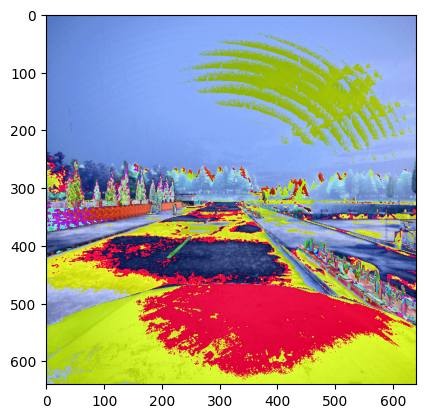

<PIL.Image.Image image mode=RGB size=640x640 at 0x7A07F90160A0>


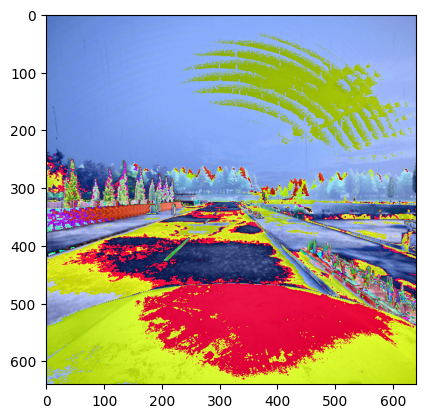

<PIL.Image.Image image mode=RGB size=640x640 at 0x7A07F9016A90>


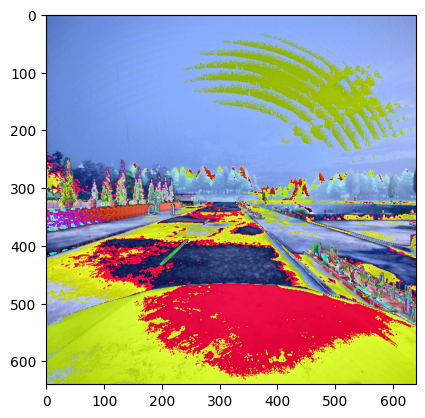

<PIL.Image.Image image mode=RGB size=640x640 at 0x7A07F9016400>


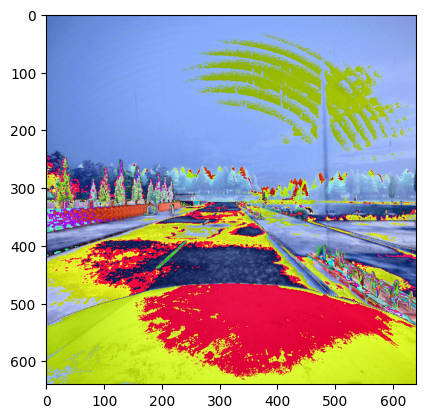

<PIL.Image.Image image mode=RGB size=640x640 at 0x7A07F90495B0>


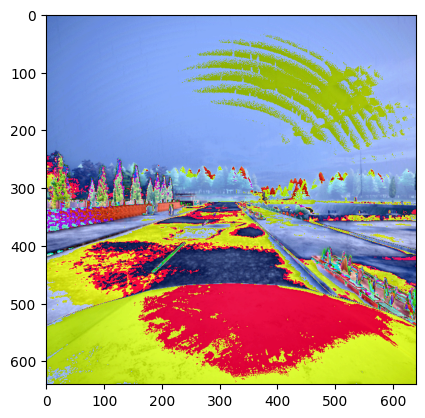

<PIL.Image.Image image mode=RGB size=640x640 at 0x7A07F9049E80>


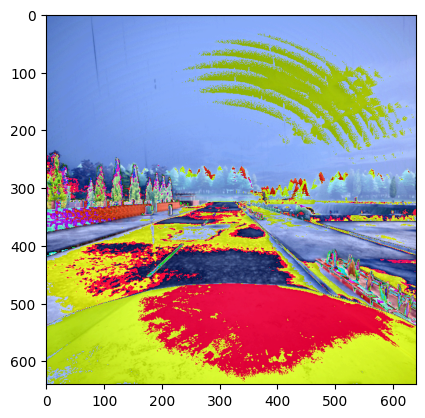

<PIL.Image.Image image mode=RGB size=640x640 at 0x7A07F9051490>


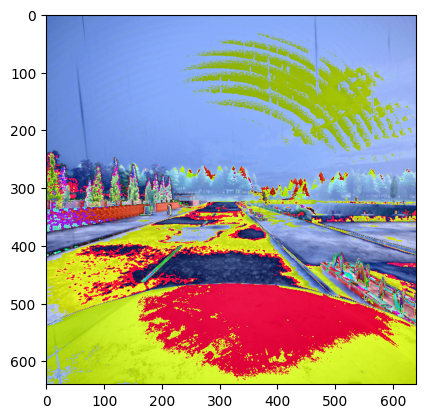

<PIL.Image.Image image mode=RGB size=640x640 at 0x7A07F8F23DF0>


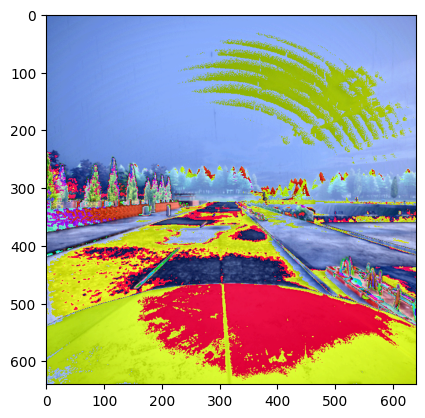

<PIL.Image.Image image mode=RGB size=640x640 at 0x7A07F8F23E20>


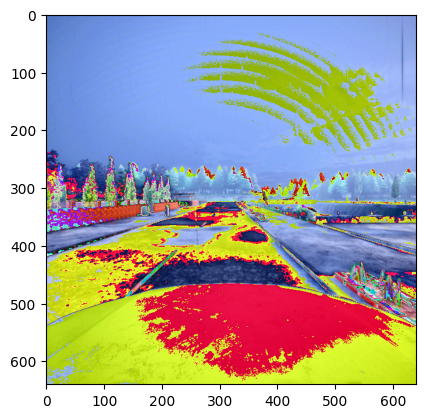

<PIL.Image.Image image mode=RGB size=640x640 at 0x7A08FBFBF4F0>


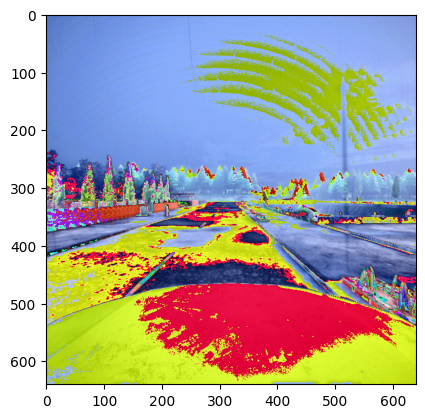

In [29]:
for i in range(len(imgs)):
    print(imgs[i])
    plt.imshow(imgs[i])
    plt.show()

In [ ]:
dataset[140][1]
# dataset[140][1]

-0.00014144745375462472